# Principal Components Analysis

**PCA** is a technique that reduces data dimensionality with minimal loss of information. It does this by transforming a set of potentially (highly) correlated variables into a set of uncorrelated ones, called *Principal Components*.

These *Principal Components* contain most of the information (high variance) about the dataset.

## Data Reduction using PCA

In this section, we try to implement PCA from scratch. [This blog](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) by Zakaria Jaadi perfectly explains the steps and reasoning behind each step of PCA.

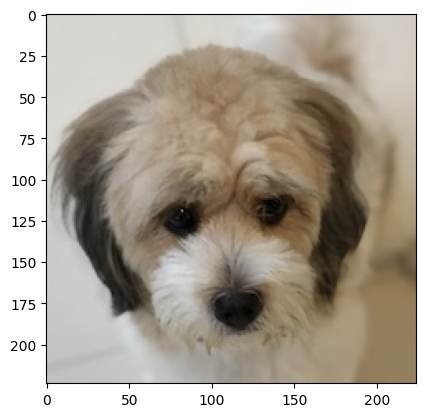

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image = np.array(Image.open('./resources/aki_dog.jpg'))/255
plt.imshow(image)
plt.show()

In [2]:
r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]

### 1. Standardization

Given our original data $X$, the mean $\mu$ and standard deviation $\sigma$, we standardize our data following this equation:

$$
Z = \frac{X-\mu}{\sigma}
$$

It is, by default, good practice to do feature rescaling (such as standardization) before performing PCA because PCA is sensitive to the variances of our data. This means that, for example, if we are looking at data points with $(x,y)$ variables and these variables have varying ranges (eg. $x$ between 0-100 and $y$ betweeen 0-10), it will lead to biased results.

We standardize to make all variables follow the same scale (and remove the bias).

In [3]:
def standardize(x):
    """
    Perform standardization of entire matrix.
    
    Input/s:
        x - matrix
        
    Output/s:
        x    - standardized matrix
        mean - mean of x
        std  - standard deviation of x
    """
    
    mean = np.mean(x)
    std = np.std(x)
    
    x = (x-mean)/std
    return x, mean, std

In [4]:
r_, r_mean, r_std = standardize(r)
g_, g_mean, g_std = standardize(g)
b_, b_mean, b_std = standardize(b)

Effectively centers our data to $\mu=0$, and $\sigma=1$.

In [5]:
print(np.mean(r_), np.std(r_))

-5.777691250600305e-17 1.0000000000000002


### 2. Finding the covariance matrix

The covariance matrix is a symmetric matrix (with the variances encoded in the diagonal) that tells us the relationship existing within our data. Some may be highly correlated that information actually becomes redundant. Our goal is to reduce data by removing this redundant information.

To compute for the covariance matrix:

$$
S = \frac{1}{n}ZZ^T
$$

[**VERIFY**] Deriving the covariance matrix, we let $\mu_X=\mathop{\mathbb{E}}[X]$:

$$
\begin{equation}
\begin{split}
Cov(X) &= \mathop{\mathbb{E}}[(X-\mu_X)(X-\mu_X)^T]\\
&= \mathop{\mathbb{E}}[(X-\mathop{\mathbb{E}}[X])(X-\mathop{\mathbb{E}}[X])^T]\\
&= \mathop{\mathbb{E}}[XX^T - X\mathop{\mathbb{E}}[X]^T - \mathop{\mathbb{E}}[X]X^T + \mathop{\mathbb{E}}[X]\mathop{\mathbb{E}}[X]^T]\\
&= \mathop{\mathbb{E}}[XX^T] - \mathop{\mathbb{E}}[X]\mathop{\mathbb{E}}[X]^T - \mathop{\mathbb{E}}[X]\mathop{\mathbb{E}}[X]^T + \mathop{\mathbb{E}}[X]\mathop{\mathbb{E}}[X]^T\\
&= \mathop{\mathbb{E}}[XX^T] - \mathop{\mathbb{E}}[X]\mathop{\mathbb{E}}[X]^T 
\end{split}
\end{equation}
$$

With our mean $\mu=0$:

$$
Cov(X) = \mathop{\mathbb{E}}[XX^T] = \frac{1}{n}XX^T
$$

In [6]:
def covariance(x):
    """
    Calculate covariance matrix.
    
    Input/s:
        x - standardized x
        
    Output/s:
        cov - covariance matrix
    """
    cov = x.dot(x.T)/len(x)
    return cov

### 3. Eigendecomposition

After finding the covariance matrix, we now determine our _principal components_ by computing for the eigenvectors and eigenvalues of our covariance matrix. The process is long, so we will be using the `eigh` function of numpy.

In [7]:
def eigen(x):
    """
    Compute for the eigenvectors and eigenvalues of the cov matrix of x.
    
    Input/s:
        x - standardized matrix
    
    Output/s:
        cov - covariance matrix
        vec - eigenvectors of the covariance matrix
        val - eigenvalues of the covariance matrix
    """
    
    cov = covariance(x)    
    val, vec = np.linalg.eigh(cov)
    
    # Sort them of decreasing eigenvalues
    val_s = np.argsort(-val)
    val = val[val_s]
    vec = vec[:, val_s]
    
    return cov, vec, val

Simply put, the **eigenvectors** (direction) are the principal axes where the data is mostly spread out, and the **eigenvalues** (magnitude) represent the variance when data is projected onto that axis.

The first principal component (eigenvector) should be the one that has the highest variance (eigenvalue), with the one following it having lesser variance and orthogonal to the previous.

We can visualize with the following animation:

![PCA](./resources/pca_)
<center>Source: <a href="https://builtin.com/data-science/step-step-explanation-principal-component-analysis">Link</a></center>

In [8]:
def PCA(x, num_components=10):
    """
    Perform principal component analysis
    
    Input/s:
        x              - standardized matrix
        num_components - number of principal components
        
    Output/s:
        p_   - principal components
        proj - projection matrix
    """
    
    cov, vec, val = eigen(x)
    
    p_ = vec[:, range(num_components)]
    proj = p_.dot(p_.T)
    return p_, proj

In [9]:
r_pc, r_proj = PCA(r_, num_components=10)
b_pc, b_proj = PCA(b_, num_components=10)
g_pc, g_proj = PCA(g_, num_components=10)

### 4. Reconstruction

We backproject:

$$
X' = PP^TZ\sigma + \mu
$$

$PP^T$, in this case, is our projection matrix already equivalent to `proj` returned by our `PCA()` function.

In [10]:
r_recon = r_proj.dot(r_)*r_std + r_mean
g_recon = g_proj.dot(g_)*g_std + g_mean
b_recon = b_proj.dot(b_)*b_std + b_mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


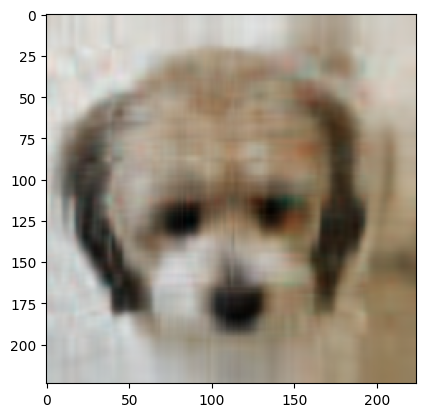

In [11]:
image_recon = np.stack((r_recon, g_recon, b_recon), axis=-1)
plt.imshow(image_recon)
plt.show()

In [12]:
import cv2

image_recon_cv = (image_recon[:,:,::-1]*255).copy()
cv2.imwrite("./resources/image_recon.jpg", image_recon_cv)

True

You can expand this to batches of data. Need editing in the matrix manipulation.